In [1]:
%matplotlib inline

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.optimizers import Adam
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [3]:
path = "../example_data/dogscats/"

In [4]:
batch_size=16

In [18]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(224,224,3)))
ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

model.add(Flatten())
FCBlock(model)
FCBlock(model)
model.add(Dense(1000, activation='softmax'))

model.load_weights('../trained_models/vgg16_tf.h5')

In [19]:
import json 
with open('../trained_models/imagenet_class_index.json') as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [20]:
def getBatches(path, batch_size):
    gen = image.ImageDataGenerator()
    return gen.flow_from_directory(path, target_size=(224,224),class_mode='categorical', shuffle=True, batch_size=batch_size)

In [21]:
batches = getBatches(path+'train', batch_size=batch_size)
val_batches = getBatches(path+'valid', batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [22]:
model.pop()

In [23]:
for layer in model.layers: layer.trainable=False

In [24]:
 model.add(Dense(batches.nb_class, activation='softmax'))

In [25]:
 model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 9514s - loss: 0.5993 - acc: 0.8497 - val_loss: 0.3726 - val_acc: 0.8975

In [26]:
model.load_weights('../trained_models/catdog.h5')

In [27]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [28]:
imgs,labels = next(val_batches)

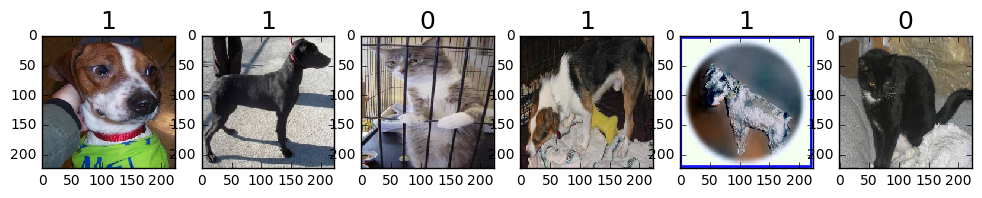

In [29]:
plots(imgs[:6], titles=np.argmax(labels, axis=1))

In [30]:
preds = model.predict(imgs[:6])

In [31]:
idxs = np.argmax(preds, axis=1)

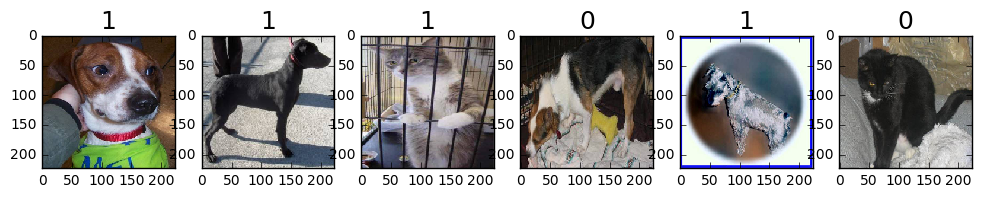

In [32]:
plots(imgs[:6], titles=idxs)

In [73]:
model.save('../trained_models/catdog.h5')